# Measurement
>  In this chapter, you'll get to the heart of image analysis: object measurement. Using a 4D cardiac time series, you'll determine if a patient is likely to have heart disease. Along the way, you'll learn the fundamentals of image segmentation, object labeling, and morphological measurement.

- toc: true 
- badges: true
- comments: true
- author: Lucas Nunes
- categories: [Datacamp]
- image: images/datacamp/___

> Note: This is a summary of the course's chapter 3 exercises "Biomedical Image Analysis in Python" at datacamp. <br>[Github repo](https://github.com/lnunesAI/Datacamp/) / [Course link](https://www.datacamp.com/tracks/machine-learning-scientist-with-python)

In [3]:
import imageio
import scipy.ndimage as ndi
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = (8, 8)

## Objects and labels

### Segment the heart

<div class=""><p>In this chapter, we'll work with <a href="https://en.wikipedia.org/wiki/Magnetic_resonance_imaging" target="_blank" rel="noopener noreferrer">magnetic resonance (MR)</a> imaging data from the <a href="http://www.cardiacatlas.org/studies/sunnybrook-cardiac-data/" target="_blank" rel="noopener noreferrer">Sunnybrook Cardiac Dataset</a>. The full image is a 3D time series spanning a single heartbeat. These data are used by radiologists to measure the <em>ejection fraction</em>: the proportion of blood ejected from the left ventricle during each stroke.</p>
<p>To begin, segment the left ventricle from a single slice of the volume (<code>im</code>). First, you'll filter and mask the image; then you'll label each object with <code>ndi.label()</code>.</p>
<p>This chapter's exercises have the following imports:</p>
<pre><code>import imageio
import numpy as np
import scipy.ndimage as ndi
import matplotlib.pyplot as plt
</code></pre></div>

In [1]:
%%capture
!wget https://github.com/lnunesAI/Datacamp/raw/main/3-skill-tracks/biomedical-image-analysis-in-python/data/sunnybrook-cardiac-mr.zip
!unzip sunnybrook-cardiac-mr.zip -d SCD2001

In [78]:
im = imageio.imread('/content/SCD2001/SCD2001_006/SCD2001_MR_117.dcm')
im = im.astype('float64')

In [57]:
def format_and_render_plot():
    'Custom function to simplify common formatting operations for exercises.'
    
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    fig = plt.gcf()
    ax = fig.axes[0]
    ax.axis('off')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(ax.get_images()[0], cax=cax)
    plt.sca(ax)
    plt.show()

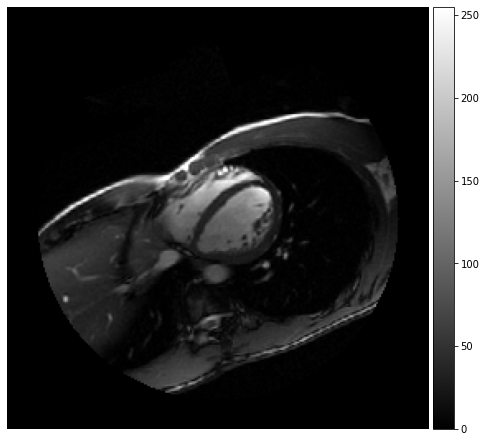

In [58]:
plt.imshow(im, cmap="gray")
format_and_render_plot()

Instructions 1/2
<ul>
<li>Apply a median filter to <code>im</code>. Set the <code>size</code> to <code>3</code>.</li>
<li>Create a mask of values greater than <code>60</code>, then use <code>ndi.binary_closing()</code> to fill small holes in it.</li>
<li>Extract a labeled array and the number of labels using <code>ndi.label()</code>.</li>
</ul>

In [79]:
# Smooth intensity values
im_filt = ndi.median_filter(im, size=3)

# Select high-intensity pixels
mask_start = np.where(im_filt > 60, 1, 0)
mask = ndi.binary_closing(mask_start)

# Label the objects in "mask"
labels, nlabels = ndi.label(mask)
print('Num. Labels:', nlabels)

Num. Labels: 26


Instructions 2/2
<li>Plot the <code>labels</code> array on top of the original image. To create an overlay, use <code>np.where</code> to convert values of 0 to <code>np.nan</code>. Then, plot the overlay with the <code>rainbow</code> colormap and set <code>alpha=0.75</code> to make it transparent.</li>

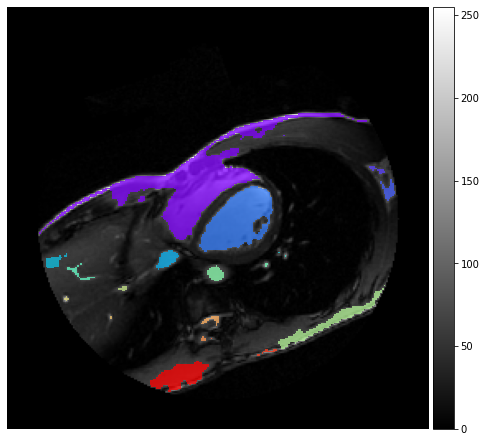

In [80]:
# Create a `labels` overlay
overlay = np.where(labels > 0, labels, np.nan)

# Use imshow to plot the overlay
plt.imshow(im, cmap='gray');
plt.imshow(overlay, cmap="rainbow", alpha=0.75)
format_and_render_plot()

**Robust image segmentation is an entire research domain, but the simple principle is to leverage intensity and location information to differentiate objects of interest from the background. Once labeled, the objects can be manipulated easily.**

### Select objects

<div class=""><p>Labels are like object "handles" - they give you a way to pick up whole sets of pixels at a time. To select a particular object:</p>
<ol>
<li>Find the label value associated with the object. </li>
<li>Create a mask of matching pixels. </li>
</ol>
<p>For this exercise, create a labeled array from the provided <code>mask</code>. Then, find the label value for the centrally-located left ventricle, and create a mask for it.</p></div>

In [62]:
from matplotlib import colors
cmap = colors.ListedColormap(['cyan'])

Instructions
<ul>
<li>Use <code>ndi.label()</code> to assign labels to each separate object in <code>mask</code>.</li>
<li>Find the index value for the left ventricle label by checking the center pixel (<code>128, 128</code>).</li>
<li>Create a mask of pixels matching the left ventricle label. Using <code>np.where</code>, set pixels labeled as <code>lv_val</code> to <code>1</code> and other values to <code>np.nan</code>.</li>
<li>Use <code>plt.imshow()</code> to overlay the selected label on the current plot.</li>
</ul>

In [94]:
labels.shape

(256, 256)

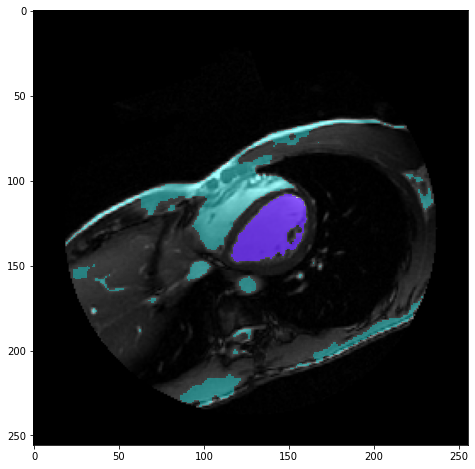

In [104]:
# Label the image "mask"
labels, nlabels = ndi.label(mask)

# Select left ventricle pixels
lv_val = labels[128, 128]
lv_mask = np.where(labels == lv_val, 1, np.nan)

# Overlay selected label
plt.imshow(im, cmap='gray')
plt.imshow(overlay, cmap=cmap, alpha=0.35)
plt.imshow(lv_mask, cmap='rainbow', alpha=0.65)
plt.show()

**When running ndi.label(), the image is traversed from top-left to bottom right, so the generated label value could change depending on how many objects are detected. You may need to plot your labeled image to get the appropriate region.**

### Extract objects

<div class=""><p>Extracting objects from the original image eliminates unrelated pixels and provides new images that can be analyzed independently.</p>
<p>The key is to crop images so that they only include the object of interest. The range of pixel indices that encompass the object is the <a href="https://en.wikipedia.org/wiki/Minimum_bounding_box" target="_blank" rel="noopener noreferrer"><em>bounding box</em></a>. </p>
<p>For this exercise, use <code>ndi.find_objects()</code> to create a new image containing only the <em>left ventricle</em>.</p></div>

In [ ]:
def format_and_render_plot():
    '''Custom function to simplify common formatting operations for exercises. 
    Operations include: 
    1. Looping through `fig.axes` and turning off axis grid.
    2. Calling `plt.tight_layout` to improve subplot spacing.
    3. Calling `plt.show()` to render plot.'''
    fig = plt.gcf()
    for ax in fig.axes:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Instructions 1/3
<p>Create the <code>labels</code> array from <code>mask</code>, then create a mask left ventricle pixels. (Use the coordinates <code>128, 128</code> to find the left ventricle label value.)</p>

In [ ]:
# Create left ventricle mask
labels, nlabels = ndi.label(mask)
lv_val = labels[128, 128]
lv_mask = np.where(labels == lv_val, 1, 0)

Instructions 2/3
<p>Find the bounding box indices for <code>lv_mask</code>. Print the number of objects found and the values for the first box.</p>

In [ ]:
# Find bounding box of left ventricle
bboxes = ndi.find_objects(lv_mask)
print('Number of objects:', len(bboxes))
print('Indices for first box:', bboxes[0])

Number of objects: 1
Indices for first box: (slice(107, 149, None), slice(116, 162, None))


Instructions 3/3
<ul>
<li>Select the portion of <code>im</code> that is within the left ventricle bounding box.</li>
<li>Plot the cropped image.</li>
</ul>

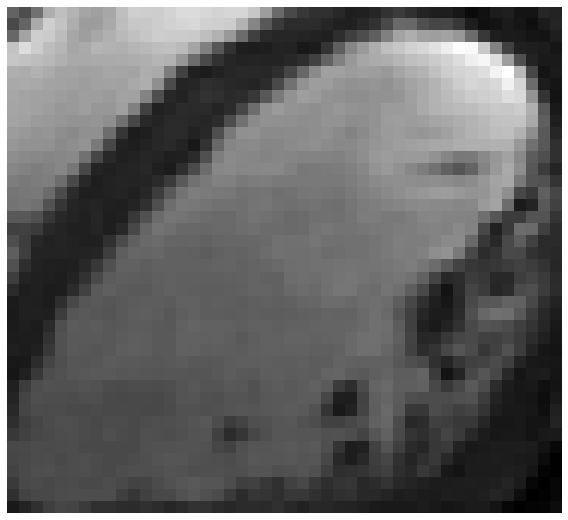

In [ ]:
# Crop to the left ventricle (index 0)
im_lv = im[bboxes[0]]

# Plot the cropped image
plt.imshow(im_lv, cmap='gray')
format_and_render_plot()

**ndi.find_objects() becomes extremely useful when dealing with 3-dimensional objects that are harder to view at a glance.**

## Measuring intensity

### Measure variance

<div class=""><p>SciPy measurement functions allow you to tailor measurements to specific sets of pixels:</p>
<ul>
<li>Specifying <code>labels</code> restricts the mask to non-zero pixels.</li>
<li>Specifying <code>index</code> value(s) returns a measure for each label value. </li>
</ul>
<p>For this exercise, calculate the intensity <strong>variance</strong> of <code>vol</code> with respect to different pixel sets. We have provided the 3D segmented image as <code>labels</code>: label 1 is the left ventricle and label 2 is a circular sample of tissue.</p>
<p>
  <img src="https://assets.datacamp.com/production/repositories/2085/datasets/d9b3a768b1f36d0affe58361c9b0f82bb819833b/Ch3_L4_cardiac-vol-exercise.gif" alt="Labeled Volume" height="200px">
</p>
<hr>
<p>After printing the variances, select the true statement from the answers below.</p></div>

In [105]:
%%capture
!wget https://github.com/lnunesAI/Datacamp/raw/main/3-skill-tracks/biomedical-image-analysis-in-python/data/SCD2001_measure_variance.npz
data = np.load('SCD2001_measure_variance.npz')
vol = data['vol']
labels = data['labels']

Instructions 1/2
<p>Using <code>vol</code> and <code>labels</code> arrays, measure the variance of pixel intensities in the specified sets of pixels. Print them to the screen.</p>

In [ ]:
# Variance for all pixels
var_all = ndi.variance(vol, labels=None, index=None)
print('All pixels:', var_all)

# Variance for labeled pixels
var_labels = ndi.variance(vol, labels)
print('Labeled pixels:', var_labels)

# Variance for each object
var_objects = ndi.variance(vol, labels, index=[1, 2])
print('Left ventricle:', var_objects[0])
print('Other tissue:', var_objects[1])

All pixels: 840.4457526156154
Labeled pixels: 2166.5887761076724
Left ventricle: 1123.4641972021984
Other tissue: 1972.7151849347783


Instructions 2/2

<pre>
Possible Answers
"Left ventricle" variance is less than "Other tissue" because it uses a smaller set of pixels.
<b>"All pixels" has the lowest variance because it has many pixels with 0 values.</b>
"Labeled pixels" high variance because it has the highest mean intensity.
</pre>

**Often, global measurements are only useful for understanding the range and distribution of the data.**

### Separate histograms

<div class=""><p>A poor tissue segmentation includes multiple tissue types, leading to a wide distribution of intensity values and more variance.</p>
<p>On the other hand, a perfectly segmented left ventricle would contain only blood-related pixels, so the histogram of the segmented values should be roughly bell-shaped.</p>
<p>For this exercise, compare the intensity distributions within <code>vol</code> for the listed sets of pixels. Use <code>ndi.histogram</code>, which also accepts  <code>labels</code> and <code>index</code> arguments.</p></div>

In [ ]:
def format_and_render_plot():
    '''Custom function to simplify common formatting operations for exercises. 
    Operations include: 
    1. Calling `plt.legend()`
    2. Calling `plt.show()` to render plot.'''
    plt.legend()
    plt.xlabel('Intensity Value')
    plt.ylabel('Proportion of Image')
    plt.ylim([0, 0.03])
    plt.show()

Instructions 1/2
<div class="exercise--instructions__content"><p>Use the <code>labels</code> and <code>index</code> arguments to extract a histogram for each of the following set of pixels in <code>vol</code>: </p>
<ol>
<li>All pixels</li>
<li>All labeled pixels</li>
<li>Left ventricle pixels (i.e., label 1)</li>
</ol></div>

In [ ]:
# Create histograms for selected pixels
hist1 = ndi.histogram(vol, min=0, max=255, bins=256)
hist2 = ndi.histogram(vol, 0, 255, 256, labels=labels)
hist3 = ndi.histogram(vol, 0, 255, 256, labels=labels, index=1)

Instructions 2/2
<li>Plot each histogram using <code>plt.plot()</code>. For each one, rescale by the total number of pixels to allow comparisons between them.</li>

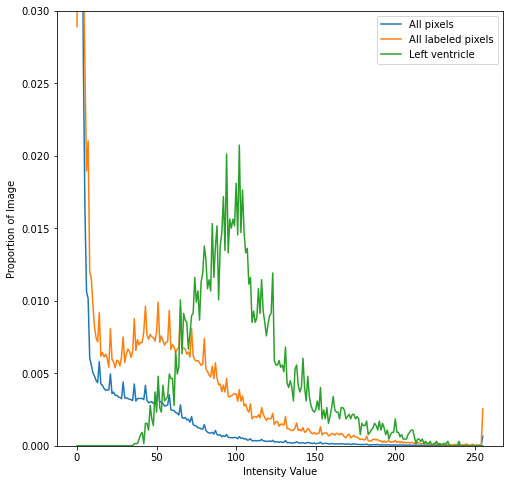

In [ ]:
# Plot the histogram density
plt.plot(hist1 / hist1.sum(), label='All pixels')
plt.plot(hist2 / hist2.sum(), label='All labeled pixels')
plt.plot(hist3 / hist3.sum(), label='Left ventricle')
format_and_render_plot()

**Notice how the left ventricle segmentation is more normally distributed than the other sets of pixels.**

## Measuring morphology

### Calculate volume

<div class=""><p>Quantifying tissue <em>morphology</em>, or shape is one primary objective of biomedical imaging. The size, shape, and uniformity of a tissue can reveal essential health insights.</p>
<p>For this exercise, measure the <em>volume</em> of the left ventricle in one 3D image (<code>vol</code>). </p>
<p>First, count the number of voxels in the left ventricle (label value of 1). Then, multiply it by the size of each voxel in mm<mjx-container class="MathJax CtxtMenu_Attached_0" jax="CHTML" role="presentation" tabindex="0" ctxtmenu_counter="0" style="font-size: 116.7%; position: relative;"><mjx-math class="MJX-TEX" aria-hidden="true"><mjx-msup><mjx-mi class="mjx-n"></mjx-mi><mjx-script style="vertical-align: 0.363em;"><mjx-mn class="mjx-n" size="s"><mjx-c class="mjx-c33"></mjx-c></mjx-mn></mjx-script></mjx-msup></mjx-math><mjx-assistive-mml role="presentation" unselectable="on" display="inline"><math xmlns="http://www.w3.org/1998/Math/MathML"><msup><mi></mi><mn>3</mn></msup></math></mjx-assistive-mml></mjx-container>. (Check <code>vol.meta</code> for the sampling rate.)</p></div>

In [35]:
%%capture
!wget https://github.com/lnunesAI/Datacamp/raw/main/3-skill-tracks/biomedical-image-analysis-in-python/data/vol_meta.pik

import pickle
meta_file = open("vol_meta.pik", 'rb')
meta = pickle.load(meta_file)

In [41]:
d0, d1, d2 = meta['sampling'] #vol.meta['sampling']
dvoxel = d0 * d1 * d2
nvoxels = ndi.sum(1, labels, index=1)
nvoxels * dvoxel

120731.82353614898

<pre>
Possible Answers
6,459 mm³
117,329 mm³
<b>120,731 mm³</b>
18,692 mm³
</pre>

**Volume is a basic but useful measure, and it is a great "reality check" when evaluating your processes.**

### Calculate distance

<div class=""><p>A <em>distance transformation</em> calculates the distance from each pixel to a given point, usually the nearest background pixel. This allows you to determine which points in the object are more interior and which are closer to edges. </p>
<p>For this exercise, use the <a href="https://en.wikipedia.org/wiki/Euclidean_distance" target="_blank" rel="noopener noreferrer">Euclidian distance</a> transform on the left ventricle object in <code>labels</code>.</p></div>

In [16]:
def format_and_render_plot():
    '''Custom function to simplify common formatting operations for exercises. 
    Operations include: 
    1. Looping through `fig.axes` and turning off axis grid.
    2. Calling `plt.tight_layout` to improve subplot spacing.
    3. Calling `plt.show()` to render plot.'''
    fig = plt.gcf()
    for ax in fig.axes:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Instructions
<ul>
<li>Create a mask of left ventricle pixels (Value of 1 in <code>labels</code>).</li>
<li>Calculate the distance to background for each pixel using <code>ndi.distance_transform_edt()</code>. Supply pixel dimensions to the <code>sampling</code> argument. </li>
<li>Print out the maximum distance and its coordinates using <code>ndi.maximum</code> and <code>ndi.maximum_position</code>.</li>
<li>Overlay a slice of the distance map on the original image. This has been done for you.</li>
</ul>

Max distance (mm): 16.320510697696196
Max location: (5, 129, 137)


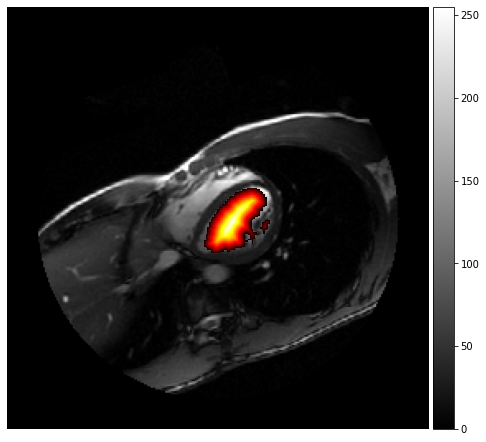

In [112]:
# Calculate left ventricle distances
lv = np.where(labels == 1, 1, 0)
dists = ndi.distance_transform_edt(lv, sampling=meta['sampling']) #vol.meta['sampling']

# Report on distances
print('Max distance (mm):', ndi.maximum(dists))
print('Max location:', ndi.maximum_position(dists))

# Plot overlay of distances
overlay = np.where(dists[5] > 0, dists[5], np.nan) 
plt.imshow(im, cmap='gray')
plt.imshow(overlay, cmap='hot')
format_and_render_plot()

**You can make inferences about the shapes of objects by looking at the distribution of distances. For example, a circle will have a uniform distribution of distances along both dimensions.**

### Pinpoint center of mass

<div class=""><p>The distance transformation reveals the most embedded portions of an object. On the other hand, <code>ndi.center_of_mass()</code> returns the coordinates for the center of an object. </p>
<p>The "mass" corresponds to intensity values, with higher values pulling the center closer to it.</p>
<p>For this exercise, calculate the center of mass for the two labeled areas. Then, plot them on top of the image.</p></div>

In [124]:
vol = data['vol']
labels = data['labels']

Instructions
<ul>
<li>Using <code>vol</code> and <code>labels</code>, calculate the center of mass for the two labeled objects. Print the coordinates.</li>
<li>Use <code>plt.scatter()</code> to add the center of mass markers to the plot. Note that scatterplots draw from the bottom-left corner. Image columns correspond to <code>x</code> values and rows to <code>y</code> values.</li>
</ul>

Label 1 center: (4.9149927898701, 125.72786150646698, 141.42957762070142)
Label 2 center: (5.133629796521218, 120.98996216281216, 119.69265418147054)


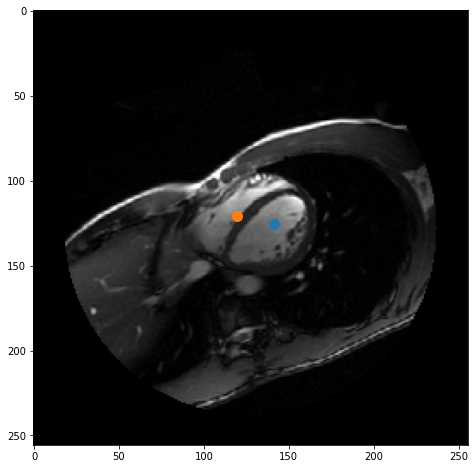

In [125]:
# Extract centers of mass for objects 1 and 2
coms = ndi.center_of_mass(vol, labels, index=[1, 2])
print('Label 1 center:', coms[0])
print('Label 2 center:', coms[1])
plt.imshow(im, cmap='gray')
# Add marks to plot
for c0, c1, c2 in coms:
    plt.scatter(c2, c1, s=100, marker='o')
plt.show()

**Some shapes, such as those with holes, may have a center of mass that is outside of them.**

## Measuring in time

### Summarize the time series

<div class=""><p>The <a href="https://en.wikipedia.org/wiki/Ejection_fraction" target="_blank" rel="noopener noreferrer"><strong>ejection fraction</strong></a> is the proportion of blood squeezed out of the left ventricle each heartbeat. To calculate it, radiologists have to identify the maximum volume (systolic volume) and the minimum volume (diastolic volume) of the ventricle.</p>
<p>
  <img src="https://assets.datacamp.com/production/repositories/2085/datasets/517ef0e708e17e0be6b3bbcc927ae3095a44a9ea/Ch3_L4_cardiac-ts-exercise.gif" alt="Slice 4 of Cardiac Timeseries" width="35%">
</p>
<p>For this exercise, create a time series of volume calculations. There are 20 time points in both <code>vol_ts</code> and <code>labels</code>. The data is ordered by <code>(time, plane, row, col)</code>.</p></div>

In [ ]:
%%capture
!wget https://github.com/lnunesAI/Datacamp/raw/main/3-skill-tracks/biomedical-image-analysis-in-python/data/SCD2001-3d-ts.npz

In [152]:
data = np.load('SCD2001-3d-ts.npz', allow_pickle=True)
vol_ts = data['vol']
labels = data['labels']
meta = data['meta'][()]

In [144]:
def format_and_render_plot():
    '''Custom function to simplify common formatting operations for exercises. 
    Operations include: 
    1. Sett `xlabel` and `ylabel`.
    2. Calling `plt.show()` to render plot.'''
    
    plt.xlabel('Timepoint')
    plt.ylabel('Volume (mm^3)')
    plt.show()

Instructions
<ul>
<li>Initialize an empty array with 20 elements using <code>np.zeros()</code>.</li>
<li>Calculate the volume of each image voxel. (Consult the <code>meta</code> dictionary for sampling rates.)</li>
<li>For each time point, count the pixels in <code>labels</code>, and update the time series array.</li>
<li>Plot the time series using <code>plt.plot()</code>.</li>
</ul>

In [142]:
meta[()]['sampling']

(10.0, 7.45454, 1.367188, 1.367188)

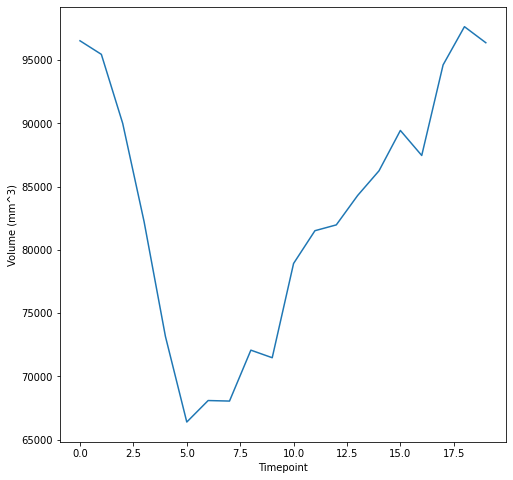

In [153]:
# Create an empty time series
ts = np.zeros(20)

# Calculate volume at each voxel
d0, d1, d2, d3 = meta['sampling'] #vol_ts.meta['sampling']
dvoxel = d1 * d2 * d3

# Loop over the labeled arrays
for t in range(20):
    nvoxels = ndi.sum(1, labels[t], index=1)
    ts[t] = nvoxels * dvoxel

# Plot the data
plt.plot(ts)
format_and_render_plot()

**You can see the pumping action of the left ventricle clearly from the time series plot - a sudden decrease followed by a refilling of the chamber.**

### Measure ejection fraction

<div class=""><p>The ejection fraction is defined as:</p>
<p><mjx-container class="MathJax CtxtMenu_Attached_0" jax="CHTML" display="true" role="presentation" tabindex="0" ctxtmenu_counter="0" style="font-size: 116.7%; position: relative;"><mjx-math display="true" class="MJX-TEX" aria-hidden="true" style="margin-left: 0px; margin-right: 0px;"><mjx-mfrac><mjx-frac type="d"><mjx-num><mjx-nstrut type="d"></mjx-nstrut><mjx-mrow><mjx-msub><mjx-mi class="mjx-i" noic="true"><mjx-c class="mjx-c1D449 TEX-I"></mjx-c></mjx-mi><mjx-script style="vertical-align: -0.15em;"><mjx-texatom size="s" texclass="ORD"><mjx-mi class="mjx-i"><mjx-c class="mjx-c1D45A TEX-I"></mjx-c></mjx-mi><mjx-mi class="mjx-i"><mjx-c class="mjx-c1D44E TEX-I"></mjx-c></mjx-mi><mjx-mi class="mjx-i"><mjx-c class="mjx-c1D465 TEX-I"></mjx-c></mjx-mi></mjx-texatom></mjx-script></mjx-msub><mjx-mo class="mjx-n" space="3"><mjx-c class="mjx-c2212"></mjx-c></mjx-mo><mjx-msub space="3"><mjx-mi class="mjx-i" noic="true"><mjx-c class="mjx-c1D449 TEX-I"></mjx-c></mjx-mi><mjx-script style="vertical-align: -0.15em;"><mjx-texatom size="s" texclass="ORD"><mjx-mi class="mjx-i"><mjx-c class="mjx-c1D45A TEX-I"></mjx-c></mjx-mi><mjx-mi class="mjx-i"><mjx-c class="mjx-c1D456 TEX-I"></mjx-c></mjx-mi><mjx-mi class="mjx-i"><mjx-c class="mjx-c1D45B TEX-I"></mjx-c></mjx-mi></mjx-texatom></mjx-script></mjx-msub></mjx-mrow></mjx-num><mjx-dbox><mjx-dtable><mjx-line type="d"></mjx-line><mjx-row><mjx-den><mjx-dstrut type="d"></mjx-dstrut><mjx-msub><mjx-mi class="mjx-i" noic="true"><mjx-c class="mjx-c1D449 TEX-I"></mjx-c></mjx-mi><mjx-script style="vertical-align: -0.15em;"><mjx-texatom size="s" texclass="ORD"><mjx-mi class="mjx-i"><mjx-c class="mjx-c1D45A TEX-I"></mjx-c></mjx-mi><mjx-mi class="mjx-i"><mjx-c class="mjx-c1D44E TEX-I"></mjx-c></mjx-mi><mjx-mi class="mjx-i"><mjx-c class="mjx-c1D465 TEX-I"></mjx-c></mjx-mi></mjx-texatom></mjx-script></mjx-msub></mjx-den></mjx-row></mjx-dtable></mjx-dbox></mjx-frac></mjx-mfrac></mjx-math><mjx-assistive-mml role="presentation" unselectable="on" display="block"><math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><mfrac><mrow><msub><mi>V</mi><mrow><mi>m</mi><mi>a</mi><mi>x</mi></mrow></msub><mo>−</mo><msub><mi>V</mi><mrow><mi>m</mi><mi>i</mi><mi>n</mi></mrow></msub></mrow><msub><mi>V</mi><mrow><mi>m</mi><mi>a</mi><mi>x</mi></mrow></msub></mfrac></math></mjx-assistive-mml></mjx-container></p>
<p>…where <mjx-container class="MathJax CtxtMenu_Attached_0" jax="CHTML" role="presentation" tabindex="0" ctxtmenu_counter="1" style="font-size: 116.7%; position: relative;"><mjx-math class="MJX-TEX" aria-hidden="true"><mjx-mi class="mjx-i"><mjx-c class="mjx-c1D449 TEX-I"></mjx-c></mjx-mi></mjx-math><mjx-assistive-mml role="presentation" unselectable="on" display="inline"><math xmlns="http://www.w3.org/1998/Math/MathML"><mi>V</mi></math></mjx-assistive-mml></mjx-container> is left ventricle volume for one 3D timepoint.</p>
<p>To close our investigation, plot slices from the maximum and minimum volumes by analyzing the volume time series (<code>ts</code>). Then, calculate the ejection fraction.</p>
<hr>
<p>After calculating the ejection fraction, review the chart below. <strong>Should this patient be concerned?</strong></p>
<p>
  <img src="https://assets.datacamp.com/production/repositories/2085/datasets/da565283afaaaf743909a49b9732fd06a1499c58/Ch3_L1_EjFracPath.png" width="35%">
</p></div>

In [148]:
ts = np.array([96535.08963925, 95462.16788662, 90000.02078232, 82238.75563667,
       73153.75586115, 66381.80817572, 68081.76212144, 68039.95997524,
       72066.90005978, 71467.73596416, 78922.45203763, 81514.18510242,
       81974.00871069, 84300.99484951, 86251.76167248, 89442.6588329 ,
       87464.02391246, 94626.12496249, 97649.81353808, 96381.81510316])

In [155]:
def format_and_render_plots():
    '''Custom function to simplify common formatting operations for exercises. 
    Operations include: 
    1. Looping through `fig.axes` and turning off axis grid.
    2. Calling `plt.tight_layout` to improve subplot spacing.
    3. Calling `plt.show()` to render plot.'''
    fig = plt.gcf()
    for ax in fig.axes:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Instructions 1/3
<ul>
<li>Get the index of the minimum and maximum volume images using <code>np.argmin()</code> and <code>np.argmax()</code>.</li>
<li>Plot the extreme volumes together. Display the images along the fifth plane, e.g. (<code>vol_ts[t, 4]</code>).</li>
</ul>

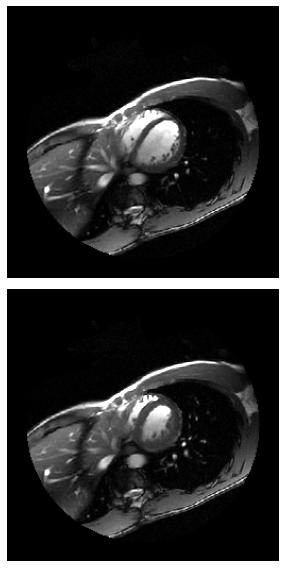

In [157]:
# Get index of max and min volumes
tmax = np.argmax(ts)
tmin = np.argmin(ts)

# Plot the largest and smallest volumes
fig, axes = plt.subplots(2,1)
axes[0].imshow(vol_ts[tmax, 4], vmax=160, cmap='gray')
axes[1].imshow(vol_ts[tmin, 4], vmax=160, cmap='gray')
format_and_render_plots()

Instructions 2/3
<li>Calculate the ejection volume and fraction using the <code>min()</code> and <code>max()</code> methods of <code>ts</code>. Print these values.</li>

In [158]:
# Calculate ejection fraction
ej_vol = ts.max() - ts.min()
ej_frac = ej_vol / ts.max()
print('Est. ejection volume (mm^3):', ej_vol)
print('Est. ejection fraction:', ej_frac)

Est. ejection volume (mm^3): 31268.00536236538
Est. ejection fraction: 0.3202054794520548


Instructions 3/3

<pre>
Possible Answers
Yes, the ejection fraction is higher than normal.
No, the ejection fraction is normal.
<b>Yes, the ejection fraction is lower than normal.</b>
</pre>

**This patient has heart failure with infarction - a serious condition. This case study illustrates a typical image analysis workflow: a single, useful metric is the result of a lot of sophisticated preprocessing, segmentation and measurement techniques.**